# Comparing a USGSCSM and ISIS camera for Dejittered HiRISE image

In [1]:
import pyproj
import pvl
import numpy as np
import os
import pandas as pd
import json
from IPython.display import Image

os.environ['ISISROOT'] = '/usgs/pkgs/isis3.7.0/install'
import knoten
from knoten import vis
import csmapi
import ale
from pysis import isis
from pysis.exceptions import ProcessError

import plotly
plotly.offline.init_notebook_mode(connected=True)

/home/acpaquette/repos/ale/ale/__init__.py:22: UserWarning:

ALESPICEROOT environment variable not set, Spice Drivers will not function correctly



## Update the ISIS cube
Requires ESP_016076_2175_REDmos_hijitreged.balance.noproj.8bit.cub in data directory

We also have to set the shapemodel to the ellipsoid because CSM does not natively support DEM intersections

In [2]:
cub_loc = 'data/ESP_016076_2175_REDmos_hijitreged.balance.noproj.8bit.cub'

try:
    isis.editlab(from_=cub_loc, grpname='Kernels', Keyword='ShapeModel', value='Null')
except ProcessError as e:
    print(f'Failed to set shapemodel for {cub_loc} to ellipsoid:\n{e.stderr}')

## Generate a USGSCSM ISD

In [3]:
usgscsm_str = ale.loads(cub_loc, formatter='usgscsm')

csm_isd = os.path.splitext(cub_loc)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

usgscsm_json = json.loads(usgscsm_str)
n_lines = usgscsm_json['image_lines']
n_samples = usgscsm_json['image_samples']

## Compare the Exterior Orientations

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

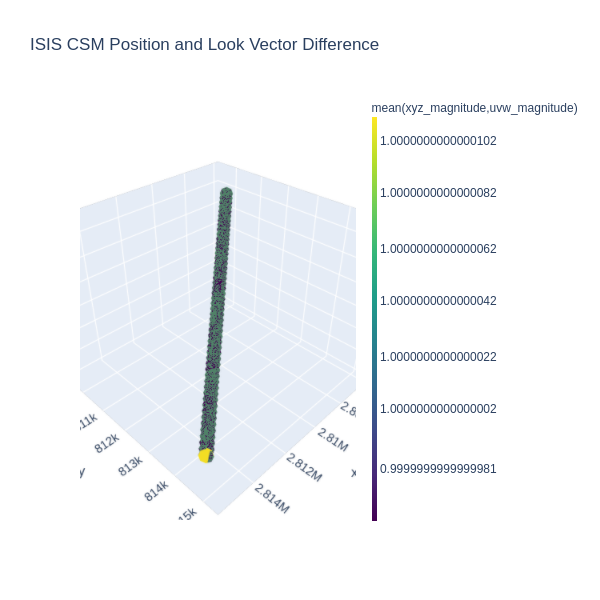

In [5]:
Image(csmisis_diff_lv_plot.to_image())

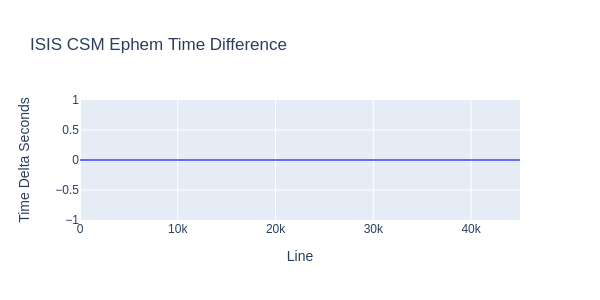

In [6]:
Image(csmisis_diff_ephem_plot.to_image())

In [7]:
external_orientation_data.describe()

,isis pos x,isis pos y,isis pos z,csm lv x,csm lv y,csm lv z,isis lv x,isis lv y,isis lv z,diffx,diffy,diffz,diffu,diffv,diffw,xyz_magnitude,uvw_magnitude,isis ephem time,csm ephem time,diff ephem
count,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,500.0
mean,2.810832e+06,812348.029736,2.234689e+06,-0.708145,-0.340549,-0.618484,-0.708145,-0.340549,-0.618484,0.000020,0.000010,-0.000029,-5.337440e-12,-2.927530e-12,7.725310e-12,6.826998e-05,1.817329e-11,3.155035e+08,3.155035e+08,0.0
std,2.275241e+03,1171.310993,3.327603e+03,0.002613,0.005171,0.000880,0.002613,0.005171,0.000880,0.000041,0.000021,0.000060,1.093834e-11,5.988364e-12,1.582114e-11,4.921283e-05,1.310797e-11,1.227762e+00,1.227762e+00,0.0
min,2.806970e+06,810360.820818,2.229042e+06,-0.713136,-0.349173,-0.620064,-0.713136,-0.349173,-0.620064,-0.000055,-0.000029,-0.000152,-2.765910e-11,-1.486272e-11,-2.125011e-11,4.667311e-08,3.436315e-15,3.155035e+08,3.155035e+08,0.0
25%,2.808864e+06,811334.536932,2.231809e+06,-0.710348,-0.345034,-0.619244,-0.710348,-0.345034,-0.619244,-0.000007,-0.000004,-0.000071,-1.292388e-11,-7.009587e-12,-2.555983e-12,2.582402e-05,6.841331e-12,3.155035e+08,3.155035e+08,0.0
50%,2.810834e+06,812348.351796,2.234690e+06,-0.708157,-0.340548,-0.618484,-0.708157,-0.340548,-0.618484,0.000021,0.000011,-0.000031,-5.552392e-12,-2.994549e-12,8.025747e-12,6.393166e-05,1.695400e-11,3.155035e+08,3.155035e+08,0.0
75%,2.812802e+06,813361.683406,2.237568e+06,-0.705942,-0.336072,-0.617725,-0.705942,-0.336072,-0.617725,0.000048,0.000025,0.000010,1.769973e-12,9.690027e-13,1.868658e-11,1.011785e-04,2.695314e-11,3.155035e+08,3.155035e+08,0.0
max,2.814688e+06,814334.025277,2.240330e+06,-0.703124,-0.331894,-0.616873,-0.703124,-0.331894,-0.616873,0.000104,0.000053,0.000081,1.472078e-11,8.187895e-12,3.994849e-11,1.912095e-04,5.081149e-11,3.155035e+08,3.155035e+08,0.0


## Compare the Ground Intersections and Back Projections

In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600, edge_pad=5.0)

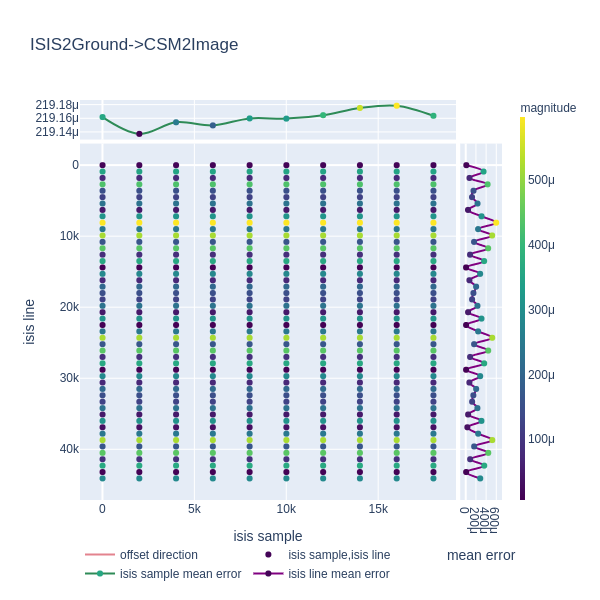

In [9]:
Image(isis2csm_plot.to_image())

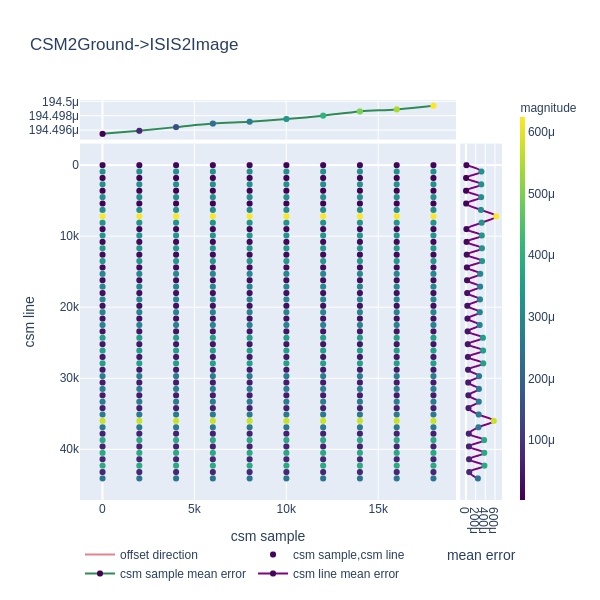

In [10]:
Image(csm2isis_plot.to_image())

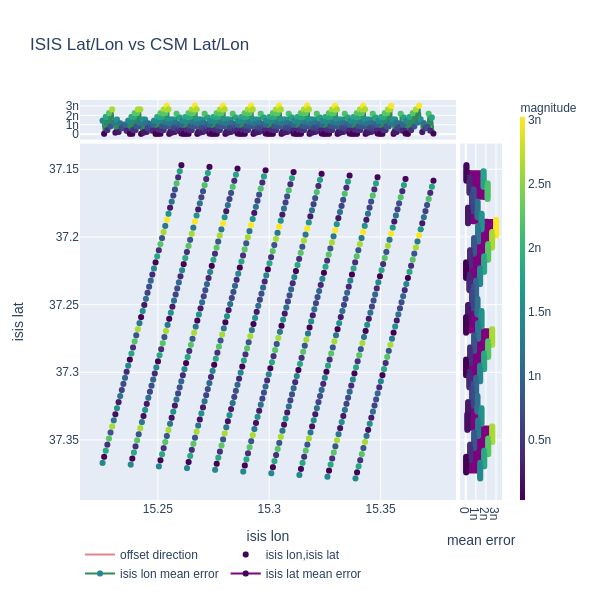

In [11]:
Image(isiscsm_plotlatlon.to_image())

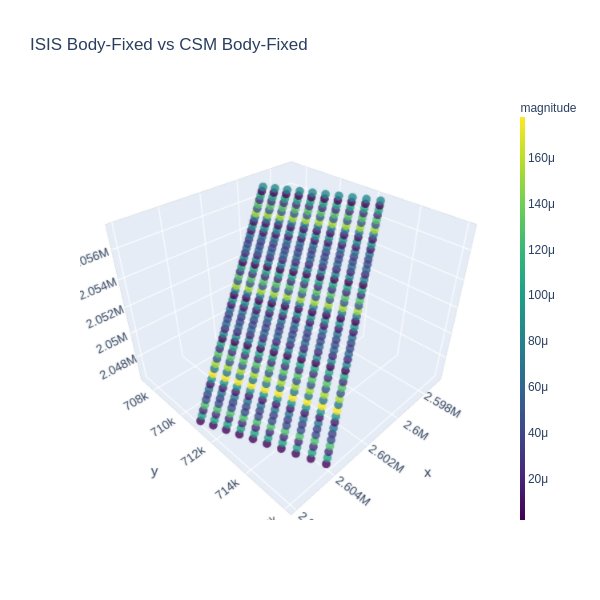

In [12]:
Image(isiscsm_plotbf.to_image())

In [13]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,5.000000e+02
mean,-0.000095,-1.766260e-07
std,0.000253,1.696641e-06
min,-0.000597,-8.032108e-06
25%,-0.000282,-1.097719e-06
50%,-0.000086,-6.276923e-08
75%,0.000072,1.018112e-06
max,0.000429,2.336286e-06


In [14]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,5.000000e+02
mean,-0.000025,1.814952e-07
std,0.000253,1.696695e-06
min,-0.000624,-2.376000e-06
25%,-0.000268,-9.643570e-07
50%,0.000020,3.540570e-08
75%,0.000061,1.076300e-06
max,0.000382,8.027000e-06
